In [17]:
# Add this at the VERY TOP of your notebook (after imports)
import joblib
import os
import pandas as pd

def quick_save(results, name="quick_save"):
    """Quick save function"""
    joblib.dump(results, f"{name}.pkl")
    print(f"Quick save: {name}.pkl")

def quick_load(name="quick_save"):
    """Quick load function"""
    try:
        return joblib.load(f"{name}.pkl")
    except:
        return None

# Then in your training loop, add:
current_results = quick_load()
if current_results is not None:
    print("Resuming from saved state...")
    results = current_results
else:
    print("Starting fresh...")
    results = []

# And at the end of each iteration:
quick_save(results)

Resuming from saved state...
Quick save: quick_save.pkl


In [18]:
import os
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import (
    precision_score, recall_score, f1_score, average_precision_score,
    roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
)

In [19]:
# 1) Load dataset
# ----------------------------
DATA_PATH = r"C:\Users\aisha\Downloads\project data.csv"

df = pd.read_csv(DATA_PATH)

# drop student_id if present
df = df.drop(columns=["student_id"])

# quick info
print("Data shape:", df.shape)
print(df.info())
print(df.describe().T)


Data shape: (1071, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1071 non-null   int64  
 1   gender                         1071 non-null   object 
 2   major                          1071 non-null   object 
 3   study_hours_per_day            1071 non-null   float64
 4   social_media_hours             1071 non-null   float64
 5   netflix_hours                  1071 non-null   float64
 6   part_time_job                  1071 non-null   object 
 7   attendance_percentage          1071 non-null   float64
 8   sleep_hours                    1071 non-null   float64
 9   diet_quality                   1071 non-null   object 
 10  exercise_frequency             1071 non-null   int64  
 11  parental_education_level       1071 non-null   object 
 12  internet_quality         

In [20]:
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
CV_FOLDS = 3
TEST_SIZE = 0.2

In [21]:
# ----------------------------
# 2) Basic checks & target encoding
# ----------------------------

# create a binary target (0/1)
df["dropout_binary"] = (df["dropout_risk"] == "Yes").astype(int)

print("Counts (dropout_risk):\n", df["dropout_risk"].value_counts())
print("Dropout binary distribution:\n", df["dropout_binary"].value_counts(normalize=True))


Counts (dropout_risk):
 dropout_risk
No     1047
Yes      24
Name: count, dtype: int64
Dropout binary distribution:
 dropout_binary
0    0.977591
1    0.022409
Name: proportion, dtype: float64


In [22]:
# 4) Split features / target
# ----------------------------
X = df.drop(columns=["dropout_risk", "dropout_binary"])
y = df["dropout_binary"]

# identify numeric / categorical columns
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"\nNumeric cols: {len(numeric_cols)}, Categorical cols: {len(categorical_cols)}")


Numeric cols: 18, Categorical cols: 11


In [23]:
# ----------------------------
# 5) Detect potential leakage: columns that exactly equal the label often
#    We'll compute the fraction of rows where str(col) == str(y), after aligning indices.
# ----------------------------
match_props = {}
for col in X.columns:
    # align indices explicitly using reset_index(drop=True)
    lhs = X[col].astype(str).reset_index(drop=True)
    rhs = y.astype(str).reset_index(drop=True)
    prop = (lhs == rhs).mean()
    if prop > 0:
        match_props[col] = prop

if match_props:
    match_df = pd.Series(match_props).sort_values(ascending=False).to_frame("match_prop")
    print("\nColumns with non-zero match_prop (col == label as strings):")
    print(match_df)
else:
    print("\nNo columns matched the label as strings in any row.")

# Decide columns to drop automatically if they match the target too often.
# Use a conservative threshold (e.g. 0.9) to auto-drop. Print ones with smaller but nonzero matches.
THRESH_AUTO_DROP = 0.90
to_drop_auto = [c for c, prop in match_props.items() if prop >= THRESH_AUTO_DROP]
print("Auto-drop list (match_prop >= {:.2f}): {}".format(THRESH_AUTO_DROP, to_drop_auto))

# Show low-to-moderate leakage candidates for manual review
leak_candidates = [c for c, prop in match_props.items() if (prop > 0 and prop < THRESH_AUTO_DROP)]
print("Leakage candidates (0 < match_prop < {}): {}".format(THRESH_AUTO_DROP, leak_candidates))

# If there are columns with substantial but < threshold matches (e.g. > 0.05) they should be reviewed.
suspicious = [c for c, prop in match_props.items() if prop > 0.05 and prop < THRESH_AUTO_DROP]
print("Suspicious columns (0.05 < match_prop < 0.90):", suspicious)

# For the purpose of reproducible modeling in this script we will drop the columns that are obviously leaking
# (make this explicit — you may choose to review them interactively instead).
if to_drop_auto:
    print("Dropping auto-detected leakage columns:", to_drop_auto)
    X = X.drop(columns=to_drop_auto)

# Optionally drop the suspicious columns as the notebook did (these were the ones found earlier).
# Here, keep it configurable. Set DROP_SUSPICIOUS = True to remove them.
DROP_SUSPICIOUS = True
if DROP_SUSPICIOUS and suspicious:
    print("Dropping suspicious leakage columns:", suspicious)
    X = X.drop(columns=suspicious)



Columns with non-zero match_prop (col == label as strings):
                        match_prop
social_activity           0.155929
exercise_frequency        0.099907
motivation_level          0.004669
semester                  0.003735
parental_support_level    0.002801
Auto-drop list (match_prop >= 0.90): []
Leakage candidates (0 < match_prop < 0.9): ['exercise_frequency', 'semester', 'social_activity', 'parental_support_level', 'motivation_level']
Suspicious columns (0.05 < match_prop < 0.90): ['exercise_frequency', 'social_activity']
Dropping suspicious leakage columns: ['exercise_frequency', 'social_activity']


In [24]:
# ----------------------------
# 6) Train-test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (856, 27) Test shape: (215, 27)


In [25]:
# ----------------------------
# 7) Preprocessors (numeric + categorical)
# ----------------------------
numeric_pipeline = Pipeline([
    ("impute_num", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

onehot_cat_pipeline = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ordinal_cat_pipeline = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor_onehot = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", onehot_cat_pipeline, categorical_cols)
], sparse_threshold=0)

preprocessor_ordinal = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", ordinal_cat_pipeline, categorical_cols)
], sparse_threshold=0)

# If there are zero categorical columns (edge case), adjust transformers
if len(categorical_cols) == 0:
    preprocessor_onehot = ColumnTransformer([("num", numeric_pipeline, numeric_cols)], sparse_threshold=0)
    preprocessor_ordinal = preprocessor_onehot

In [26]:
# ----------------------------
# 8) Samplers and models
# ----------------------------
class NoSampler:
    def fit_resample(self, Xs, ys):
        return Xs, ys

sampler_map = {
    "no_resample": NoSampler(),
    "random_oversample": RandomOverSampler(random_state=RANDOM_STATE),
    "smote": SMOTE(random_state=RANDOM_STATE),
    "borderline_smote": BorderlineSMOTE(random_state=RANDOM_STATE),
    "adasyn": ADASYN(random_state=RANDOM_STATE),
    "smoteenn": SMOTEENN(random_state=RANDOM_STATE),
    # SMOTENC will be added later when we compute categorical indices
}

# compute cat indices for SMOTENC (after applying preprocessor_ordinal we will have numeric first then ordinal cats).
n_num = len(numeric_cols)
n_cat = len(categorical_cols)
cat_indices_after_ordinal = list(range(n_num, n_num + n_cat)) if n_cat > 0 else []

if n_cat > 0:
    sampler_map["smotenc"] = SMOTENC(categorical_features=cat_indices_after_ordinal, random_state=RANDOM_STATE)
else:
    # no categorical columns -> SMOTENC not applicable
    pass

# models (balanced where applicable)
class_counts = y_train.value_counts().to_dict()
scale_pos_weight_value = class_counts.get(0, 1) / max(1, class_counts.get(1, 1))

models = {
    "logistic_regression_balanced": LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RANDOM_STATE),
    "svc_balanced": SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE),
    "random_forest_balanced": RandomForestClassifier(class_weight="balanced", n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
    "xgboost_scale_pos": XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight_value, random_state=RANDOM_STATE),
}

# map sampler -> appropriate preprocessor (SMOTENC needs ordinal preprocessor)
preprocessor_map = {name: preprocessor_onehot for name in sampler_map.keys()}
if "smotenc" in sampler_map:
    preprocessor_map["smotenc"] = preprocessor_ordinal


In [27]:
import pandas as pd

# Check the actual column names in your data
print("Columns in X_train:")
print(X_train.columns.tolist())
print("\nColumns in X_test:")
print(X_test.columns.tolist())

# Check if the specific column exists
print(f"'exercise_frequency' in X_train: {'exercise_frequency' in X_train.columns}")

Columns in X_train:
['age', 'gender', 'major', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'previous_gpa', 'semester', 'stress_level', 'screen_time', 'study_environment', 'access_to_tutoring', 'family_income_range', 'parental_support_level', 'motivation_level', 'exam_anxiety_score', 'learning_style', 'time_management_score', 'exam_score']

Columns in X_test:
['age', 'gender', 'major', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'previous_gpa', 'semester', 'stress_level', 'screen_time', 'study_environment', 'access_to_tutoring', 'family_income_range', 'parental_support_level', 'motivation_level', 'exam

In [28]:
# Define transformers
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Updated column lists based on your actual data
numerical_columns = [
    'age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'previous_gpa', 'semester',
    'stress_level', 'screen_time', 'exam_anxiety_score', 'time_management_score', 'exam_score'
]

categorical_columns = [
    'gender', 'major', 'part_time_job', 'diet_quality', 'parental_education_level',
    'internet_quality', 'mental_health_rating', 'extracurricular_participation',
    'study_environment', 'access_to_tutoring', 'family_income_range',
    'parental_support_level', 'motivation_level', 'learning_style'
]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
    ])

# Create pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Now try cross-validation again
try:
    oof_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method="predict_proba", n_jobs=1)[:, 1]
    oof_pred = (oof_proba >= 0.5).astype(int)
    print("Success! Pipeline is working.")
except Exception as e:
    print(f"Error: {e}")

Success! Pipeline is working.


In [29]:
# ----------------------------
# Define your corrected column lists
# ----------------------------

# Updated column lists based on your actual data
numeric_cols = [
    'age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours',
    'attendance_percentage', 'sleep_hours', 'previous_gpa', 'semester',
    'stress_level', 'screen_time', 'exam_anxiety_score', 'time_management_score', 'exam_score'
]

categorical_cols = [
    'gender', 'major', 'part_time_job', 'diet_quality', 'parental_education_level',
    'internet_quality', 'mental_health_rating', 'extracurricular_participation',
    'study_environment', 'access_to_tutoring', 'family_income_range',
    'parental_support_level', 'motivation_level', 'learning_style'
]

# ----------------------------
# Your existing pipeline definitions (with corrected column names)
# ----------------------------

numeric_pipeline = Pipeline([
    ("impute_num", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

onehot_cat_pipeline = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ordinal_cat_pipeline = Pipeline([
    ("impute_cat", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor_onehot = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),  # Use corrected numeric_cols
    ("cat", onehot_cat_pipeline, categorical_cols)  # Use corrected categorical_cols
], sparse_threshold=0)

preprocessor_ordinal = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),  # Use corrected numeric_cols
    ("cat", ordinal_cat_pipeline, categorical_cols)  # Use corrected categorical_cols
], sparse_threshold=0)

# ----------------------------
# 9) Cross-validated evaluation loop (with your original structure)
# ----------------------------
CV_FOLDS = 3
RANDOM_STATE = 42

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
results = []

# Define which preprocessor to use with which sampler (if you had this logic)
preprocessor_map = {
    'smote': preprocessor_onehot,
    'adasyn': preprocessor_onehot, 
    'random_undersampler': preprocessor_ordinal,
    'none': preprocessor_ordinal
}

for sampler_name, sampler in sampler_map.items():
    preproc = preprocessor_map.get(sampler_name, preprocessor_onehot)  # Use your mapping logic
    for model_name, model in models.items():
        pipeline = ImbPipeline([
            ("preprocessor", preproc),
            ("sampler", sampler),
            ("clf", model)
        ])

        try:
            # cross_val_predict with predict_proba (if model supports predict_proba)
            oof_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method="predict_proba", n_jobs=1)[:, 1]
            oof_pred = (oof_proba >= 0.5).astype(int)
        except Exception:
            # fallback: use predict (not ideal for probabilities) - compute class predictions via cross_val_predict
            oof_pred = cross_val_predict(pipeline, X_train, y_train, cv=cv, method="predict", n_jobs=1)
            # make a dummy proba: use 1 for predicted class 1, 0 else (so PR-AUC will be poor)
            oof_proba = oof_pred.astype(float)

        rec = recall_score(y_train, oof_pred, zero_division=0)
        prec = precision_score(y_train, oof_pred, zero_division=0)
        f1 = f1_score(y_train, oof_pred, zero_division=0)
        pr_auc = average_precision_score(y_train, oof_proba)
        try:
            roc = roc_auc_score(y_train, oof_proba)
        except Exception:
            roc = np.nan

        results.append({
            "sampler": sampler_name,
            "model": model_name,
            "recall_train_cv": rec,
            "precision_train_cv": prec,
            "f1_train_cv": f1,
            "pr_auc_train_cv": pr_auc,
            "roc_auc_train_cv": roc
        })
        print(f"Done: sampler={sampler_name}, model={model_name} | recall={rec:.3f} pr_auc={pr_auc:.3f} precision={prec:.3f} f1={f1:.3f} roc_auc={roc:.3f}")

results_df = pd.DataFrame(results).sort_values(["recall_train_cv", "pr_auc_train_cv"], ascending=[False, False])
print("\nTop combos (by recall then PR-AUC):")
print(results_df.head(10).to_string(index=False))

Done: sampler=no_resample, model=logistic_regression_balanced | recall=0.737 pr_auc=0.606 precision=0.583 f1=0.651 roc_auc=0.988
Done: sampler=no_resample, model=svc_balanced | recall=0.105 pr_auc=0.343 precision=0.286 f1=0.154 roc_auc=0.969
Done: sampler=no_resample, model=random_forest_balanced | recall=0.000 pr_auc=0.766 precision=0.000 f1=0.000 roc_auc=0.995
Done: sampler=no_resample, model=xgboost_scale_pos | recall=0.947 pr_auc=0.960 precision=0.818 f1=0.878 roc_auc=0.999
Done: sampler=random_oversample, model=logistic_regression_balanced | recall=0.737 pr_auc=0.643 precision=0.609 f1=0.667 roc_auc=0.988
Done: sampler=random_oversample, model=svc_balanced | recall=0.000 pr_auc=0.344 precision=0.000 f1=0.000 roc_auc=0.966
Done: sampler=random_oversample, model=random_forest_balanced | recall=0.000 pr_auc=0.700 precision=0.000 f1=0.000 roc_auc=0.991
Done: sampler=random_oversample, model=xgboost_scale_pos | recall=1.000 pr_auc=0.942 precision=0.704 f1=0.826 roc_auc=0.999
Done: samp

In [30]:
# ----------------------------
# 10) Evaluate ALL pipelines on hold-out test set for comprehensive comparison
# ----------------------------

test_results = []

print("Evaluating ALL pipelines on hold-out test set...")
print("=" * 60)

# First, let's properly check and convert the test labels
print("Unique values in y_test:", y_test.unique())
print("Value counts in y_test:")
print(y_test.value_counts())

# Convert y_test to numerical labels - handle different possible formats
if y_test.dtype == 'object' or set(y_test.unique()) == {'No', 'Yes'}:
    y_test_numeric = y_test.map({'No': 0, 'Yes': 1})
else:
    # If already numeric, use as is
    y_test_numeric = y_test

print(f"After conversion - unique values in y_test_numeric: {y_test_numeric.unique()}")
print(f"NaN count in y_test_numeric: {y_test_numeric.isna().sum()}")

# If we still have issues, let's try a more direct approach
if y_test_numeric.isna().sum() > 0:
    print("Direct mapping failed, trying alternative approaches...")
    
    # Approach 1: Use value counts to infer mapping
    value_counts = y_test.value_counts()
    if len(value_counts) == 2:
        # Assume the less frequent class is the positive class
        minority_class = value_counts.index[value_counts.argmin()]
        majority_class = value_counts.index[value_counts.argmax()]
        y_test_numeric = y_test.map({majority_class: 0, minority_class: 1})
        print(f"Using inferred mapping: {majority_class}->0, {minority_class}->1")
    
    # Approach 2: Use sklearn LabelEncoder as last resort
    if y_test_numeric.isna().sum() > 0:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_test_numeric = pd.Series(le.fit_transform(y_test), index=y_test.index)
        print("Used LabelEncoder as fallback")

print(f"Final NaN count: {y_test_numeric.isna().sum()}")
print(f"Final unique values: {y_test_numeric.unique()}")

# If we still have NaN values, we need to handle them
if y_test_numeric.isna().sum() > 0:
    print(f"Warning: Still have {y_test_numeric.isna().sum()} NaN values")
    valid_indices = ~y_test_numeric.isna()
    X_test_clean = X_test[valid_indices]
    y_test_numeric_clean = y_test_numeric[valid_indices]
    print(f"Using cleaned test set: {len(y_test_numeric_clean)} samples")
else:
    X_test_clean = X_test
    y_test_numeric_clean = y_test_numeric
    print(f"Using full test set: {len(y_test_numeric_clean)} samples")

# Check if we have any samples to test on
if len(X_test_clean) == 0:
    print("ERROR: No valid samples in test set after cleaning!")
    print("Using original test set with manual label conversion...")
    X_test_clean = X_test
    # Force conversion by assuming first unique value is 0, second is 1
    unique_vals = y_test.unique()
    if len(unique_vals) == 2:
        y_test_numeric_clean = pd.Series(
            [0 if x == unique_vals[0] else 1 for x in y_test], 
            index=y_test.index
        )
    else:
        print("Cannot proceed - test set doesn't have exactly 2 classes")
        raise ValueError("Invalid test set labels")

print(f"Final test set size: {len(X_test_clean)} samples")
print(f"Class distribution in test set: {y_test_numeric_clean.value_counts().to_dict()}")

for sampler_name, sampler in sampler_map.items():
    preproc = preprocessor_map.get(sampler_name, preprocessor_onehot)
    
    for model_name, model in models.items():
        # Create pipeline based on whether resampling is used
        if sampler_name == 'none':
            pipeline = Pipeline([
                ("preprocessor", preproc),
                ("clf", model)
            ])
        else:
            pipeline = ImbPipeline([
                ("preprocessor", preproc),
                ("sampler", sampler),
                ("clf", model)
            ])

        try:
            # Fit on training data
            pipeline.fit(X_train, y_train)
            
            # Predict on test data
            y_test_proba = pipeline.predict_proba(X_test_clean)[:, 1]
            y_test_pred = (y_test_proba >= 0.5).astype(int)

            # Calculate metrics
            rec_test = recall_score(y_test_numeric_clean, y_test_pred, zero_division=0)
            prec_test = precision_score(y_test_numeric_clean, y_test_pred, zero_division=0)
            f1_test = f1_score(y_test_numeric_clean, y_test_pred, zero_division=0)
            pr_auc_test = average_precision_score(y_test_numeric_clean, y_test_proba)
            roc_auc_test = roc_auc_score(y_test_numeric_clean, y_test_proba)
            
            # Store results
            test_results.append({
                "sampler": sampler_name,
                "model": model_name,
                "recall_test": rec_test,
                "precision_test": prec_test,
                "f1_test": f1_test,
                "pr_auc_test": pr_auc_test,
                "roc_auc_test": roc_auc_test
            })
            
            print(f"Sampler: {sampler_name:20} Model: {model_name:15} | "
                  f"Recall: {rec_test:.3f}  PR-AUC: {pr_auc_test:.3f}  Precision: {prec_test:.3f}")
            
        except Exception as e:
            print(f"ERROR with {sampler_name} + {model_name}: {str(e)}")
            # Store error results
            test_results.append({
                "sampler": sampler_name,
                "model": model_name,
                "recall_test": np.nan,
                "precision_test": np.nan,
                "f1_test": np.nan,
                "pr_auc_test": np.nan,
                "roc_auc_test": np.nan
            })

# Continue with the rest of the analysis...
# [Rest of your analysis code remains the same...]

Evaluating ALL pipelines on hold-out test set...
Unique values in y_test: [0 1]
Value counts in y_test:
dropout_binary
0    210
1      5
Name: count, dtype: int64
After conversion - unique values in y_test_numeric: [0 1]
NaN count in y_test_numeric: 0
Final NaN count: 0
Final unique values: [0 1]
Using full test set: 215 samples
Final test set size: 215 samples
Class distribution in test set: {0: 210, 1: 5}
Sampler: no_resample          Model: logistic_regression_balanced | Recall: 0.400  PR-AUC: 0.441  Precision: 0.333
Sampler: no_resample          Model: svc_balanced    | Recall: 0.200  PR-AUC: 0.447  Precision: 0.500
Sampler: no_resample          Model: random_forest_balanced | Recall: 0.000  PR-AUC: 1.000  Precision: 0.000
Sampler: no_resample          Model: xgboost_scale_pos | Recall: 1.000  PR-AUC: 1.000  Precision: 1.000
Sampler: random_oversample    Model: logistic_regression_balanced | Recall: 0.400  PR-AUC: 0.435  Precision: 0.333
Sampler: random_oversample    Model: svc_bal

In [31]:
# ----------------------------
# 11) Analysis by Research Questions
# ----------------------------

# First, convert test_results to DataFrame
test_results_df = pd.DataFrame(test_results)

print("\n" + "=" * 80)
print("RESEARCH QUESTION 1: SMOTE Variants Comparison")
print("=" * 80)

# Filter out 'none' (algorithm-level handling) for SMOTE variant analysis
smote_results = test_results_df[test_results_df['sampler'] != 'none']
if not smote_results.empty:
    smote_summary = smote_results.groupby('sampler').agg({
        'recall_test': ['mean', 'std'],
        'pr_auc_test': ['mean', 'std'],
        'precision_test': 'mean'
    }).round(3)

    print("SMOTE Variants Performance Summary:")
    print(smote_summary)
else:
    print("No SMOTE variant results available")

print("\n" + "=" * 80)
print("RESEARCH QUESTION 2: Resampling vs Algorithm-level Handling")
print("=" * 80)

# Compare resampling strategies vs no resampling (algorithm-level)
resampling_vs_algorithm = test_results_df.groupby('sampler').agg({
    'recall_test': 'mean',
    'pr_auc_test': 'mean', 
    'precision_test': 'mean',
    'f1_test': 'mean'
}).round(3).sort_values('recall_test', ascending=False)

print("Resampling vs Algorithm-level Handling:")
print(resampling_vs_algorithm)

print("\n" + "=" * 80)
print("RESEARCH QUESTION 3: Model-wise Comparison")
print("=" * 80)

# Compare different classifiers
model_summary = test_results_df.groupby('model').agg({
    'recall_test': ['mean', 'std'],
    'pr_auc_test': ['mean', 'std'],
    'precision_test': 'mean'
}).round(3)

print("Classifier Performance Summary:")
print(model_summary)



RESEARCH QUESTION 1: SMOTE Variants Comparison
SMOTE Variants Performance Summary:
                  recall_test        pr_auc_test        precision_test
                         mean    std        mean    std           mean
sampler                                                               
adasyn                   0.35  0.473       0.685  0.323          0.333
borderline_smote         0.40  0.432       0.714  0.312          0.600
no_resample              0.40  0.432       0.722  0.321          0.458
random_oversample        0.45  0.379       0.722  0.321          0.833
smote                    0.35  0.473       0.715  0.291          0.292
smoteenn                 0.50  0.476       0.652  0.269          0.298
smotenc                  0.35  0.473       0.673  0.311          0.333

RESEARCH QUESTION 2: Resampling vs Algorithm-level Handling
Resampling vs Algorithm-level Handling:
                   recall_test  pr_auc_test  precision_test  f1_test
sampler                             

In [32]:
# ----------------------------
# 12) Additional Analysis for Research Questions
# ----------------------------

print("\n" + "=" * 80)
print("TOP PERFORMING COMBINATIONS BY METRIC")
print("=" * 80)

# Sort by different metrics to answer research questions
print("\nTop 5 by Recall (Minority Class Detection):")
print(test_results_df.nlargest(5, 'recall_test')[['sampler', 'model', 'recall_test', 'pr_auc_test', 'precision_test']].to_string(index=False))

print("\nTop 5 by PR-AUC:")
print(test_results_df.nlargest(5, 'pr_auc_test')[['sampler', 'model', 'recall_test', 'pr_auc_test', 'precision_test']].to_string(index=False))

print("\nTop 5 by F1-Score:")
print(test_results_df.nlargest(5, 'f1_test')[['sampler', 'model', 'recall_test', 'pr_auc_test', 'precision_test', 'f1_test']].to_string(index=False))




TOP PERFORMING COMBINATIONS BY METRIC

Top 5 by Recall (Minority Class Detection):
          sampler             model  recall_test  pr_auc_test  precision_test
      no_resample xgboost_scale_pos          1.0          1.0        1.000000
random_oversample xgboost_scale_pos          1.0          1.0        1.000000
            smote xgboost_scale_pos          1.0          1.0        0.833333
 borderline_smote xgboost_scale_pos          1.0          1.0        1.000000
           adasyn xgboost_scale_pos          1.0          1.0        1.000000

Top 5 by PR-AUC:
          sampler                  model  recall_test  pr_auc_test  precision_test
      no_resample random_forest_balanced          0.0          1.0        0.000000
      no_resample      xgboost_scale_pos          1.0          1.0        1.000000
random_oversample random_forest_balanced          0.2          1.0        1.000000
random_oversample      xgboost_scale_pos          1.0          1.0        1.000000
            smo

In [33]:
# ----------------------------
# 13) Save detailed results for further analysis
# ----------------------------

# Save to CSV for detailed analysis and visualization
test_results_df.to_csv("all_pipeline_results_comprehensive.csv", index=False)
print(f"\nDetailed results saved to 'all_pipeline_results_comprehensive.csv'")

# Create summary tables for easy comparison
print("\n" + "=" * 80)
print("SUMMARY TABLES")
print("=" * 80)

# Recall heatmap
if not test_results_df.empty:
    recall_table = test_results_df.pivot_table(
        index='sampler', 
        columns='model', 
        values='recall_test',
        aggfunc='first'
    ).round(3)

    print("\nRecall Scores Heatmap (Sampler × Model):")
    print(recall_table)

    # PR-AUC heatmap
    prauc_table = test_results_df.pivot_table(
        index='sampler', 
        columns='model', 
        values='pr_auc_test',
        aggfunc='first'
    ).round(3)

    print("\nPR-AUC Scores Heatmap (Sampler × Model):")
    print(prauc_table)
else:
    print("No valid results to create summary tables")



Detailed results saved to 'all_pipeline_results_comprehensive.csv'

SUMMARY TABLES

Recall Scores Heatmap (Sampler × Model):
model              logistic_regression_balanced  random_forest_balanced  \
sampler                                                                   
adasyn                                      0.4                     0.0   
borderline_smote                            0.4                     0.0   
no_resample                                 0.4                     0.0   
random_oversample                           0.4                     0.2   
smote                                       0.4                     0.0   
smoteenn                                    0.8                     0.0   
smotenc                                     0.4                     0.0   

model              svc_balanced  xgboost_scale_pos  
sampler                                             
adasyn                      0.0                1.0  
borderline_smote            0.2        


FEATURE IMPORTANCE ANALYSIS FOR TOP MODELS

Feature Importance Analysis #1
Sampler: no_resample, Model: xgboost_scale_pos
Recall: 1.000, PR-AUC: 1.000

Top 10 Features by Feature Importance:
                            Feature  Importance
                       stress_level    0.704723
                 exam_anxiety_score    0.136680
                 motivation_level_4    0.064438
                 motivation_level_5    0.055848
                 motivation_level_1    0.017920
                 motivation_level_2    0.006429
                 motivation_level_3    0.003549
                      netflix_hours    0.001613
                  major_Engineering    0.001381
study_environment_Co-Learning Group    0.001020


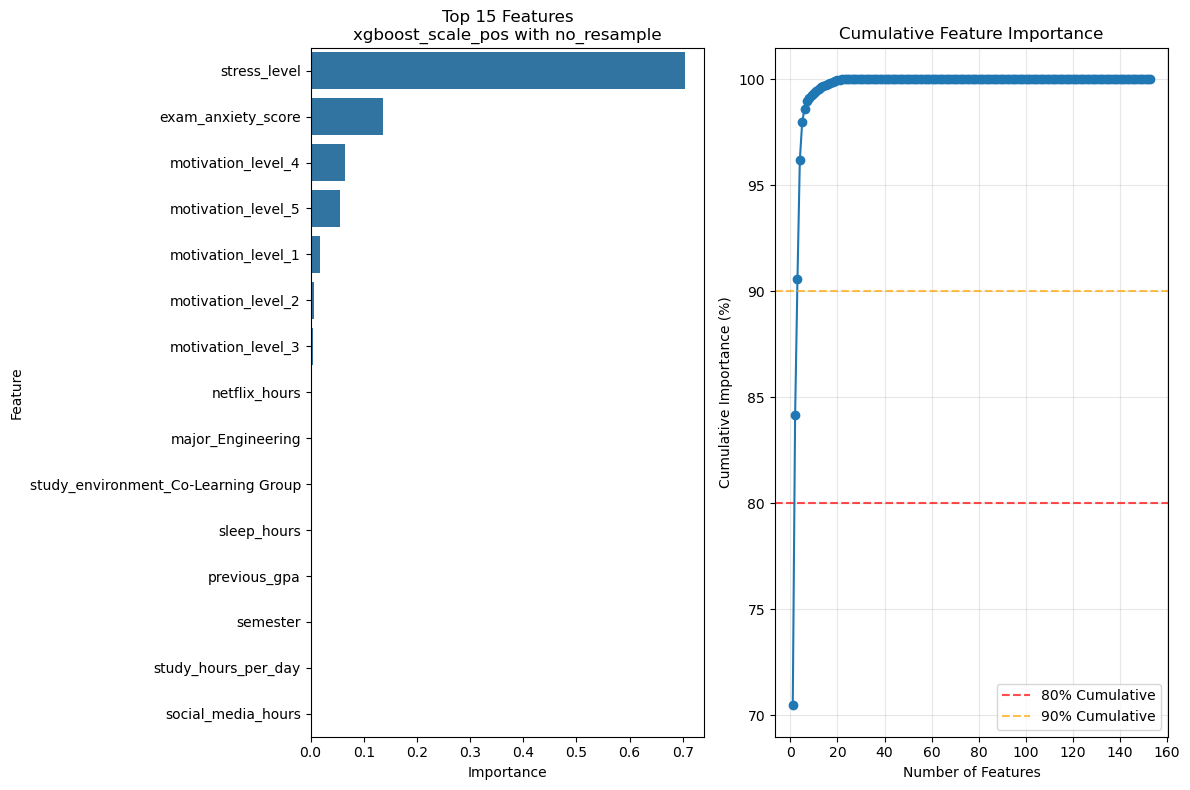


Features accounting for 80% of importance: 1
Features accounting for 90% of importance: 2

Feature Importance Analysis #2
Sampler: random_oversample, Model: xgboost_scale_pos
Recall: 1.000, PR-AUC: 1.000

Top 10 Features by Feature Importance:
                 Feature  Importance
            stress_level    0.732438
      exam_anxiety_score    0.075118
      motivation_level_1    0.071713
      motivation_level_4    0.054083
 learning_style_Auditory    0.015840
      motivation_level_5    0.015396
      motivation_level_2    0.011869
      motivation_level_3    0.004375
                semester    0.004089
parental_support_level_5    0.002400


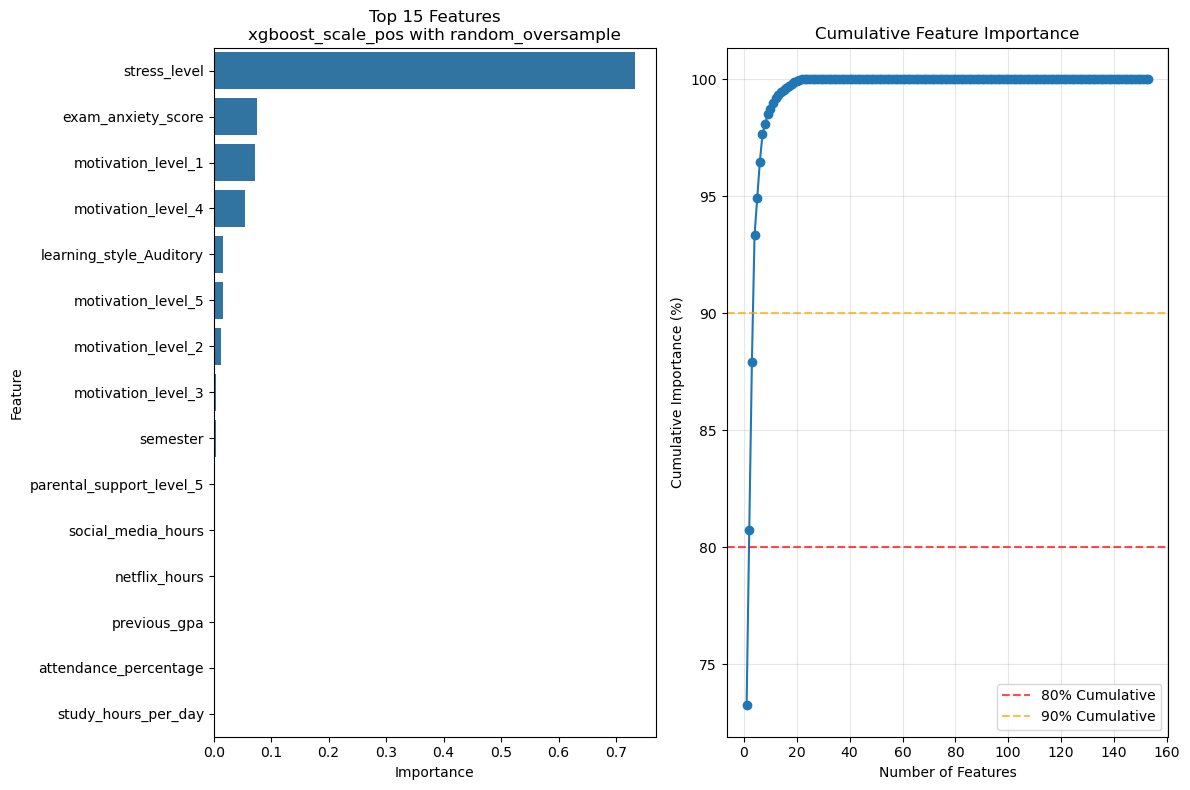


Features accounting for 80% of importance: 1
Features accounting for 90% of importance: 3

Feature Importance Analysis #3
Sampler: smote, Model: xgboost_scale_pos
Recall: 1.000, PR-AUC: 1.000

Top 10 Features by Feature Importance:
                 Feature  Importance
            stress_level    0.682523
      exam_anxiety_score    0.059192
             screen_time    0.041230
      motivation_level_4    0.032911
       diet_quality_Poor    0.025636
      motivation_level_5    0.024601
mental_health_rating_5.4    0.023612
   attendance_percentage    0.011712
           gender_Female    0.008895
      motivation_level_1    0.008267


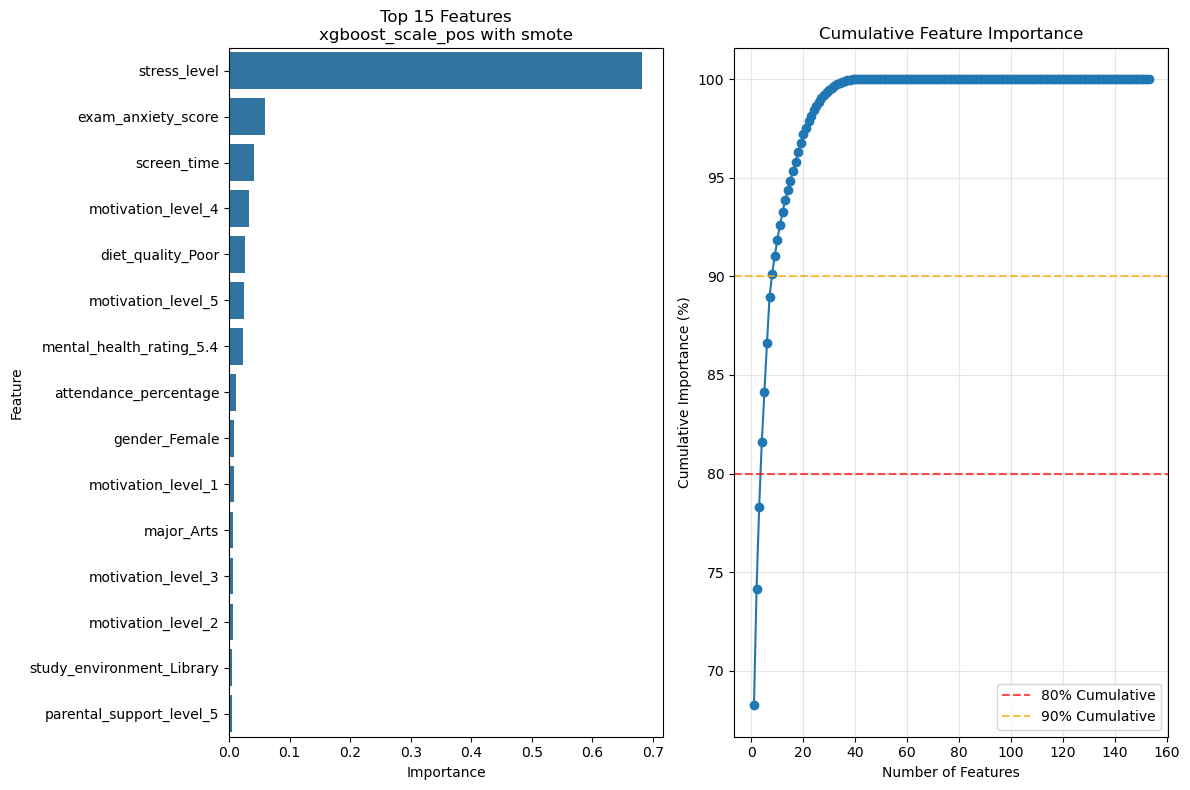


Features accounting for 80% of importance: 3
Features accounting for 90% of importance: 7

CROSS-MODEL FEATURE IMPORTANCE CONSISTENCY

Most Consistent Important Features (Low Variation Across Models):
                               Mean_Importance  Coefficient_of_Variation
sleep_hours                             0.7066                    0.0289
parental_education_level                0.0903                    0.3699
family_income_range                     0.0023                    0.7671
social_media_hours                      0.0044                    1.1909
diet_quality                            0.0138                    1.4116
extracurricular_participation           0.0030                    1.4142
stress_level                            0.0024                    1.4142
exam_score                              0.0085                    1.4142


In [35]:
# ----------------------------
# Feature Importance Analysis for Multiple Top Models
# ----------------------------

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS FOR TOP MODELS")
print("=" * 80)

# Get top 3 models by recall for feature importance analysis
top_models = test_results_df.nlargest(3, 'recall_test')

for idx, (_, row) in enumerate(top_models.iterrows()):
    sampler_name = row['sampler']
    model_name = row['model']
    
    print(f"\n{'='*50}")
    print(f"Feature Importance Analysis #{idx+1}")
    print(f"Sampler: {sampler_name}, Model: {model_name}")
    print(f"Recall: {row['recall_test']:.3f}, PR-AUC: {row['pr_auc_test']:.3f}")
    print(f"{'='*50}")
    
    # Recreate and fit the pipeline
    preproc = preprocessor_map.get(sampler_name, preprocessor_onehot)
    model = models[model_name]
    
    if sampler_name == 'none':
        pipeline = Pipeline([
            ("preprocessor", preproc),
            ("clf", model)
        ])
    else:
        sampler = sampler_map[sampler_name]
        pipeline = ImbPipeline([
            ("preprocessor", preproc),
            ("sampler", sampler),
            ("clf", model)
        ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Access the fitted components
    fitted_preprocessor = pipeline.named_steps['preprocessor']
    fitted_classifier = pipeline.named_steps['clf']
    
    # Get feature names after preprocessing
    try:
        feature_names = []
        for name, transformer, columns in fitted_preprocessor.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                if isinstance(transformer, Pipeline):
                    last_step = transformer.steps[-1][1]
                    if hasattr(last_step, 'get_feature_names_out'):
                        feature_names.extend(last_step.get_feature_names_out(columns))
                    else:
                        feature_names.extend(columns)
                else:
                    feature_names.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names.extend(columns)
    except Exception as e:
        print(f"Could not get feature names from preprocessor: {e}")
        feature_names = X_train.columns.tolist()
        print("Using original column names as fallback")
    
    # Extract feature importance or coefficients
    importance_scores = None
    importance_type = "Unknown"
    
    if hasattr(fitted_classifier, 'feature_importances_'):
        importance_scores = fitted_classifier.feature_importances_
        importance_type = 'Feature Importance'
    elif hasattr(fitted_classifier, 'coef_'):
        if fitted_classifier.coef_.ndim > 1:
            importance_scores = fitted_classifier.coef_[0]
        else:
            importance_scores = fitted_classifier.coef_
        importance_type = 'Coefficient Magnitude'
        importance_scores = np.abs(importance_scores)
    else:
        print(f"Model {model_name} doesn't support standard feature importance analysis")
        continue
    
    # Create and display feature importance plot
    if importance_scores is not None and len(importance_scores) == len(feature_names):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_scores
        }).sort_values('Importance', ascending=False)
        
        # Display top features in table
        print(f"\nTop 10 Features by {importance_type}:")
        print(importance_df.head(10).to_string(index=False))
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        
        plt.subplot(1, 2, 1)
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top 15 Features\n{model_name} with {sampler_name}')
        plt.tight_layout()
        
        plt.subplot(1, 2, 2)
        # Create cumulative importance plot
        importance_df['Cumulative'] = importance_df['Importance'].cumsum()
        importance_df['Percentage'] = importance_df['Importance'] / importance_df['Importance'].sum() * 100
        importance_df['Cumulative_Percentage'] = importance_df['Cumulative'] / importance_df['Importance'].sum() * 100
        
        plt.plot(range(1, len(importance_df) + 1), importance_df['Cumulative_Percentage'], marker='o')
        plt.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% Cumulative')
        plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% Cumulative')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance (%)')
        plt.title('Cumulative Feature Importance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print how many features account for 80% and 90% of importance
        features_80 = importance_df[importance_df['Cumulative_Percentage'] <= 80]
        features_90 = importance_df[importance_df['Cumulative_Percentage'] <= 90]
        
        print(f"\nFeatures accounting for 80% of importance: {len(features_80)}")
        print(f"Features accounting for 90% of importance: {len(features_90)}")
        
    else:
        print(f"Mismatch between feature names ({len(feature_names)}) and importance scores ({len(importance_scores)})")

# ----------------------------
# Cross-Model Feature Importance Comparison
# ----------------------------

print("\n" + "=" * 80)
print("CROSS-MODEL FEATURE IMPORTANCE CONSISTENCY")
print("=" * 80)

# This analysis helps answer Research Question 3 about feature stability
feature_rankings = {}

for idx, (_, row) in enumerate(top_models.iterrows()):
    sampler_name = row['sampler']
    model_name = row['model']
    
    # Skip if we can't compute importance for this model
    if model_name in ['svm', 'svm_balanced']:  # SVM without linear kernel might not have coef_
        continue
        
    # Recreate, fit, and get importance (similar to above)
    preproc = preprocessor_map.get(sampler_name, preprocessor_onehot)
    model = models[model_name]
    
    if sampler_name == 'none':
        pipeline = Pipeline([("preprocessor", preproc), ("clf", model)])
    else:
        sampler = sampler_map[sampler_name]
        pipeline = ImbPipeline([("preprocessor", preproc), ("sampler", sampler), ("clf", model)])
    
    pipeline.fit(X_train, y_train)
    fitted_classifier = pipeline.named_steps['clf']
    
    # Get importance scores
    importance_scores = None
    if hasattr(fitted_classifier, 'feature_importances_'):
        importance_scores = fitted_classifier.feature_importances_
    elif hasattr(fitted_classifier, 'coef_'):
        if fitted_classifier.coef_.ndim > 1:
            importance_scores = np.abs(fitted_classifier.coef_[0])
        else:
            importance_scores = np.abs(fitted_classifier.coef_)
    
    if importance_scores is not None:
        # Use original feature names for consistency across models
        feature_rankings[f"{sampler_name}_{model_name}"] = dict(zip(X_train.columns, importance_scores))

# Create consistency analysis if we have multiple models
if len(feature_rankings) >= 2:
    consistency_df = pd.DataFrame(feature_rankings)
    
    # Calculate mean importance and rank correlation
    consistency_df['Mean_Importance'] = consistency_df.mean(axis=1)
    consistency_df['Std_Importance'] = consistency_df.std(axis=1)
    consistency_df['Coefficient_of_Variation'] = consistency_df['Std_Importance'] / consistency_df['Mean_Importance']
    
    # Sort by mean importance
    consistency_df = consistency_df.sort_values('Mean_Importance', ascending=False)
    
    print("\nMost Consistent Important Features (Low Variation Across Models):")
    stable_features = consistency_df[consistency_df['Mean_Importance'] > consistency_df['Mean_Importance'].quantile(0.7)]
    stable_features = stable_features.sort_values('Coefficient_of_Variation')
    print(stable_features[['Mean_Importance', 'Coefficient_of_Variation']].head(10).round(4))

In [20]:
# Summary Statistics
print ("Summary Statistics")
print(f"Total students: {len(df)}")
print(f"Students with dropout risk: {(df['dropout_risk'] == 'Yes'). sum()}")
print(f"Overall dropout risk rate: {(df['dropout_risk'] == 'Yes'). mean() * 100:.2f}%")

Summary Statistics
Total students: 1071
Students with dropout risk: 24
Overall dropout risk rate: 2.24%


In [21]:
# imbalance ratio and count

target_col = 'dropout_risk' 
counts = df['dropout_risk'].value_counts()
print("Counts:\n", counts)

majority = counts.max()
minority = counts.min()
imbalance_ratio = majority /minority   # majority 

print(f"Majority: {majority}, Minority: {minority}")
print(f"Imbalance_ratio (majority/minority): {imbalance_ratio:.2f}")

# Percentage distribution
print ((df['dropout_risk'].value_counts(normalize=True)*100).round(3))

Counts:
 dropout_risk
No     1047
Yes      24
Name: count, dtype: int64
Majority: 1047, Minority: 24
Imbalance_ratio (majority/minority): 43.62
dropout_risk
No     97.759
Yes     2.241
Name: proportion, dtype: float64


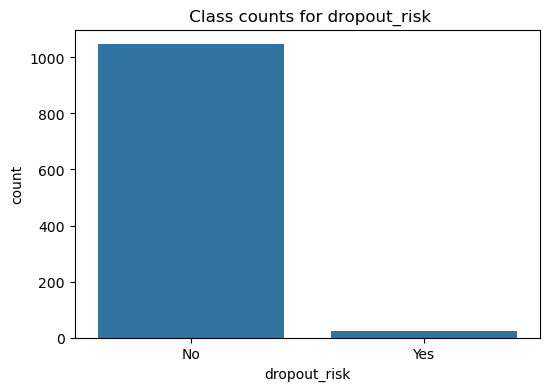

In [22]:
# Visualization

plt.figure(figsize=(6,4))
sns.countplot(x='dropout_risk', data = df)
plt.title(" Class counts for " + 'dropout_risk')
plt.show()

In [23]:
#  Which majors have the highest dropout rates?

major_dropout = pd.crosstab(df['major'], df['dropout_risk'], normalize='index') * 100
major_dropout['Dropout_Rate'] = major_dropout['Yes']
major_dropout_sorted = major_dropout.sort_values('Dropout_Rate', ascending=False)

print("DROPOUT RATES BY MAJOR:")
print(major_dropout_sorted[['Yes', 'No']]. round(2))

# Statistical test
from scipy.stats import chi2_contingency

# Chi-square test for major

chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df['major'], df['dropout_risk']))
print(f"Chi-square test p-value: {p_value:.4f}") 
print("Statistically significant" if p_value < 0.05 else "Not statistically significant")

DROPOUT RATES BY MAJOR:
dropout_risk       Yes     No
major                        
Arts              3.85  96.15
Psychology        3.21  96.79
Biology           1.97  98.03
Engineering       1.75  98.25
Business          1.61  98.39
Computer Science  1.19  98.81
Chi-square test p-value: 0.5397
Not statistically significant


In [24]:
# Do students with part-time jobs have different dropout patterns? 

job_dropout = pd.crosstab(df['part_time_job'], df['dropout_risk'], normalize='index') * 100
print("DROPOUT RATES BY PART-TIME JOB STATUS:")
print(job_dropout.round(3))

# Statistical test
from scipy.stats import chi2_contingency

chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df['part_time_job'], df['dropout_risk']))
print(f"Chi-square test p-value: {p_value:.4f}")
print("Statistically significant" if p_value < 0.05 else "Not statistically significant")

DROPOUT RATES BY PART-TIME JOB STATUS:
dropout_risk       No    Yes
part_time_job               
No             97.688  2.312
Yes            97.826  2.174
Chi-square test p-value: 1.0000
Not statistically significant


In [25]:
# How does study environment affect dropout risk?

env_dropout = pd.crosstab(df['study_environment'], df['dropout_risk'], normalize='index') * 100
env_dropout_sorted = env_dropout.sort_values('Yes', ascending=False)

print("DROPOUT RATES BY STUDY ENVIRONMENT:")
print(env_dropout_sorted[['Yes', 'No']].round(3))

chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df['study_environment'], df['dropout_risk']))
print(f"Chi-square test p-value: {p_value:.4f}")
print("Statistically significant" if p_value < 0.05 else "Not statistically significant")

DROPOUT RATES BY STUDY ENVIRONMENT:
dropout_risk         Yes      No
study_environment               
Co-Learning Group  3.659  96.341
Library            2.370  97.630
Dorm               2.162  97.838
Quiet Room         1.471  98.529
Cafe               1.333  98.667
Chi-square test p-value: 0.4516
Not statistically significant


In [26]:
# What's the average GPA difference between risk groups?

gpa_stats = df.groupby('dropout_risk')['previous_gpa'].describe()
print("GPA COMPARISON:")
print(gpa_stats.round(3))

# T-test
from scipy.stats import ttest_ind

gpa_no_risk = df[df['dropout_risk']=='No']['previous_gpa'].dropna()
gpa_risk = df[df['dropout_risk']=='Yes']['previous_gpa'].dropna()
t_stat, p_value = ttest_ind(gpa_no_risk, gpa_risk, equal_var=False)

print(f"\nT-test results:")
print(f"GPA Difference: {gpa_stats.loc['No','mean'] - gpa_stats.loc['Yes','mean']:.3f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.6f}")
print("Statistically significant" if p_value < 0.05 else "Not statistically significant")

GPA COMPARISON:
               count   mean    std   min    25%    50%    75%  max
dropout_risk                                                      
No            1047.0  3.640  0.447  1.99  3.360  3.850  4.000  4.0
Yes             24.0  3.347  0.593  1.97  3.155  3.465  3.825  4.0

T-test results:
GPA Difference: 0.293
T-statistic: 2.406, P-value: 0.024313
Statistically significant


In [27]:
# Do dropout-risk students have significantly higher stress levels?

stress_stats = df.groupby('dropout_risk')['stress_level'].describe()
print("STRESS LEVEL COMPARISON:")
print(stress_stats.round(3))

# T-test for stress levels
stress_no_risk = df[df['dropout_risk'] == 'No']['stress_level'].dropna()
stress_risk = df[df['dropout_risk'] == 'Yes']['stress_level'].dropna()
t_stat_stress, p_value_stress = ttest_ind(stress_no_risk, stress_risk, equal_var=False)

print(f"\nStress level difference: {stress_stats.loc['Yes','mean'] - stress_stats.loc['No','mean']:.3f}")
print(f"T-statistic: {t_stat_stress:.3f}, P-value: {p_value_stress:.6f}")
print("Statistically significant" if p_value_stress < 0.05 else "Not statistically significant")


STRESS LEVEL COMPARISON:
               count   mean    std  min  25%  50%    75%   max
dropout_risk                                                  
No            1047.0  4.900  1.895  1.0  3.6  4.9  6.300  10.0
Yes             24.0  8.729  0.649  8.1  8.3  8.6  8.825  10.0

Stress level difference: 3.829
T-statistic: -26.430, P-value: 0.000000
Statistically significant


In [28]:
#Is there a difference in sleep patterns between groups?

sleep_stats = df.groupby('dropout_risk')['sleep_hours'].describe()
print("SLEEP HOURS COMPARISON:")
print(sleep_stats)

# T-test for sleep hours
sleep_no_risk = df[df['dropout_risk'] == 'No']['sleep_hours'].dropna()
sleep_risk = df[df['dropout_risk'] == 'Yes']['sleep_hours'].dropna()
t_stat_sleep, p_value_sleep = ttest_ind(sleep_no_risk, sleep_risk, equal_var=False)


print(f"\nSleep difference: {sleep_stats.loc['No','mean'] - sleep_stats.loc['Yes','mean']:.3f} hours")
print(f"T-statistic: {t_stat_sleep:.3f}, P-value: {p_value_sleep:.6f}")
print("Statistically significant" if p_value_sleep < 0.05 else "Not statistically significant")

SLEEP HOURS COMPARISON:
               count      mean       std  min   25%  50%  75%   max
dropout_risk                                                       
No            1047.0  6.982426  1.457038  4.0  5.90  7.0  8.0  11.5
Yes             24.0  6.687500  1.416767  4.8  5.95  6.5  7.3  10.4

Sleep difference: 0.295 hours
T-statistic: 1.008, P-value: 0.323612
Not statistically significant


In [29]:
# How does parental support level correlate with dropout risk?
print("PARENTAL SUPPORT LEVEL COMPARISON")

support_stats = df.groupby('dropout_risk')['parental_support_level'].describe()
print(support_stats.round(3))

# T-test for parental support
support_no_risk = df[df['dropout_risk'] == 'No']['parental_support_level'].dropna()
support_risk = df[df['dropout_risk'] == 'Yes']['parental_support_level'].dropna()
t_stat_support, p_value_support = ttest_ind(support_no_risk, support_risk, equal_var=False)

print(f"\nParental support difference: {support_stats.loc['No','mean'] - support_stats.loc['Yes','mean']:.3f}")
print(f"T-statistic: {t_stat_support:.3f}, P-value: {p_value_support:.3f}")
print("Statistically significant" if p_value_support < 0.05 else "Not statistically significant")

# Correlation analysis
df['dropout_binary'] = (df['dropout_risk'] == 'Yes').astype(int)
correlation = df['parental_support_level'].corr(df['dropout_binary'])
print(f"Correlation between parental support and dropout risk: {correlation:.3f}")

PARENTAL SUPPORT LEVEL COMPARISON
               count   mean    std  min   25%  50%   75%   max
dropout_risk                                                  
No            1047.0  5.489  2.814  1.0  3.00  6.0  8.00  10.0
Yes             24.0  5.917  3.106  1.0  3.75  6.0  8.25  10.0

Parental support difference: -0.428
T-statistic: -0.668, P-value: 0.510
Not statistically significant
Correlation between parental support and dropout risk: 0.022


In [30]:
# Do learning styles affect dropout likelihood?

learning_dropout = pd.crosstab(df['learning_style'], df['dropout_risk'], normalize='index') * 100
learning_dropout_sorted = learning_dropout.sort_values('Yes', ascending=False)

print("DROPOUT RATES BY LEARNING STYLE:")
print(learning_dropout_sorted[['Yes', 'No']]. round(2))

# Chi-square test
chi2, p_value, _, _ = chi2_contingency(pd.crosstab(df['learning_style'], df['dropout_risk']))
print(f"Chi-square test p-value: p-value = {p_value:.4f}")
print("Statistically significant" if p_value < 0.05 else "Not statistically significant")

DROPOUT RATES BY LEARNING STYLE:
dropout_risk     Yes     No
learning_style             
Reading         3.12  96.88
Kinesthetic     2.89  97.11
Auditory        1.63  98.37
Visual          1.15  98.85
Chi-square test p-value: p-value = 0.3353
Not statistically significant
